# 02 – Daily Usage Analytics (5-Minute → Daily Aggregation)

## Purpose

This notebook transforms raw **5-minute regional demand data** into **daily-level usage metrics** for each NEM region.

We aggregate the `dispatch_region_5min` table (created in Notebook 01) to compute, per region and day:

- Average 5-minute demand
- Daily peak and minimum demand
- Total daily energy in MWh

## How it fits into the overall methodology

This is **Layer 2 – Daily Analytics** in the project pipeline:

1. **Layer 1 – Raw 5-minute data**: `dispatch_region_5min` (Notebook 01)  
2. **Layer 2 – Daily usage**: `daily_usage` (this notebook)  
3. Later notebooks build on `daily_usage` to:
   - Derive monthly patterns
   - Analyse weekday profiles
   - Compute region-level KPIs

The resulting `daily_usage` table becomes the main input for:
- Time-series analysis
- Operational insights
- Power BI daily dashboards


## Step 1 – Load Environment Variables and Connect to PostgreSQL


We need to read from the **base raw table** `dispatch_region_5min` stored in PostgreSQL.

Using a `.env` file to manage credentials ensures:

- The notebook is portable and secure (no passwords in code).
- Multiple notebooks in the project can reuse the same connection pattern.
- BI tools (like Power BI) can point to the same database later.

This step simply establishes a working connection to the database.


In [1]:
import os
import pandas as pd
from sqlalchemy import create_engine, text
from dotenv import load_dotenv

# -------- 1. LOAD ENV VARIABLES --------
load_dotenv()   # This loads the .env file

DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")

# -------- 2. CREATE ENGINE SAFELY --------
engine = create_engine(
    f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)

# -------- 3. TEST CONNECTION --------
with engine.connect() as conn:
    result = conn.execute(text("SELECT 1;")).fetchall()
    print("✅ DB connection OK:", result)

# -------- 4. LOAD SAMPLE FROM dispatch_region_5min --------
query = """
    SELECT *
    FROM dispatch_region_5min
    ORDER BY settlement_ts
    LIMIT 10;
"""

df_sample = pd.read_sql(query, engine)

print("\n📊 Sample rows:")
print(df_sample)

print("\n📋 Columns:", df_sample.columns.tolist())


✅ DB connection OK: [(1,)]

📊 Sample rows:
        settlement_ts region_id  total_demand
0 2025-01-01 00:05:00       SA1       1379.47
1 2025-01-01 00:05:00      TAS1        989.78
2 2025-01-01 00:05:00      NSW1       7251.07
3 2025-01-01 00:05:00      QLD1       6444.99
4 2025-01-01 00:05:00       SA1       1379.47
5 2025-01-01 00:05:00      NSW1       7251.07
6 2025-01-01 00:05:00      TAS1        989.78
7 2025-01-01 00:05:00      QLD1       6444.99
8 2025-01-01 00:05:00      VIC1       4339.00
9 2025-01-01 00:05:00      VIC1       4339.00

📋 Columns: ['settlement_ts', 'region_id', 'total_demand']


## Step 2 – Load Raw 5-Minute Demand (`dispatch_region_5min`)



The **daily metrics** are derived from the raw 5-minute demand table created earlier:

- `dispatch_region_5min`
  - `settlement_ts` – 5-minute timestamp
  - `region_id` – NEM region (NSW1, QLD1, etc.)
  - `total_demand` – MW at that interval

In this step we load that table into a pandas DataFrame so we can:

- Convert timestamps to calendar dates
- Group by `date + region_id`
- Compute daily averages, peaks, minima, and energy

This connects **Layer 1 (raw data)** to **Layer 2 (daily analytics)**.


In [2]:
df = df_sample = None  # reset if needed

import pandas as pd

df = pd.read_sql("""
    SELECT *
    FROM dispatch_region_5min
    ORDER BY settlement_ts;
""", engine)

df["settlement_ts"] = pd.to_datetime(df["settlement_ts"])
df["date"] = df["settlement_ts"].dt.date

df.head()


,settlement_ts,region_id,total_demand,date
0,2025-01-01 00:05:00,TAS1,989.78,2025-01-01
1,2025-01-01 00:05:00,NSW1,7251.07,2025-01-01
2,2025-01-01 00:05:00,SA1,1379.47,2025-01-01
3,2025-01-01 00:05:00,QLD1,6444.99,2025-01-01
4,2025-01-01 00:05:00,VIC1,4339.00,2025-01-01


## Step 3 – Aggregate 5-Minute Data into Daily Usage Metrics


Working directly with 5-minute data is:

- Too granular for many business questions
- Hard to visualise and explain to non-technical stakeholders

Most operational and planning decisions are made at a **daily** level (e.g., “How much energy did NSW consume yesterday?”).

So we aggregate **per region and date**:

- **Average 5-minute demand** – typical load profile for the day  
- **Daily peak** – highest instantaneous demand for risk and capacity analysis  
- **Daily minimum** – lowest demand for low-load / renewable penetration analysis  
- **Total daily energy (MWh)** – actual energy served, used for cost, billing, and reporting

This transforms raw operational readings into **daily business metrics**.


In [3]:
daily_group = df.groupby(["date", "region_id"])

df_daily = daily_group["total_demand"].agg(
    avg_5min_demand="mean",
    daily_peak="max",
    daily_min="min",
    total_demand_sum="sum"
).reset_index()

# Convert MW to MWh (5-minute intervals → 5/60 hours)
df_daily["total_daily_energy_mwh"] = df_daily["total_demand_sum"] * (5.0 / 60.0)

df_daily = df_daily.drop(columns=["total_demand_sum"])

df_daily.head()


,date,region_id,avg_5min_demand,daily_peak,daily_min,total_daily_energy_mwh
0,2025-01-01,NSW1,6774.125714,9434.59,4534.57,486043.5200
1,2025-01-01,QLD1,6039.234634,7808.79,4554.92,433315.0850
2,2025-01-01,SA1,862.286655,1518.36,10.55,61869.0675
3,2025-01-01,TAS1,999.820767,1104.47,920.09,71737.1400
4,2025-01-01,VIC1,3293.134390,4488.60,1400.13,236282.3925


In [4]:
# Create new table
df_daily.to_sql(
    "daily_usage",
    engine,
    index=False,
    if_exists="replace"
)

print("✅ daily_usage table created:", len(df_daily), "rows")

✅ daily_usage table created: 1520 rows


### Daily_Usage


### STEP 1 — Load daily_usage from Postgres

In [5]:
df_daily = pd.read_sql("SELECT * FROM daily_usage ORDER BY date, region_id;", engine)
df_daily.head()


,date,region_id,avg_5min_demand,daily_peak,daily_min,total_daily_energy_mwh
0,2025-01-01,NSW1,6774.125714,9434.59,4534.57,486043.5200
1,2025-01-01,QLD1,6039.234634,7808.79,4554.92,433315.0850
2,2025-01-01,SA1,862.286655,1518.36,10.55,61869.0675
3,2025-01-01,TAS1,999.820767,1104.47,920.09,71737.1400
4,2025-01-01,VIC1,3293.134390,4488.60,1400.13,236282.3925


## Step 4 – Data Quality and Summary Checks on Daily Metrics

### Why we are doing this

Before saving `daily_usage` and using it in other notebooks or dashboards, we need to ensure:

- There are no obvious missing values in key columns.
- The numeric ranges look realistic (no crazy negative values).
- Basic descriptive statistics make sense (mean, min, max).

This is a **sanity check** step to validate the daily aggregation logic.


In [6]:
df_daily[[
    "region_id",
    "avg_5min_demand",
    "daily_peak",
    "daily_min",
    "total_daily_energy_mwh"
]].isnull().sum()


region_id                 0
avg_5min_demand           0
daily_peak                0
daily_min                 0
total_daily_energy_mwh    0
dtype: int64

In [7]:
df_daily[[
    "avg_5min_demand",
    "daily_peak",
    "daily_min",
    "total_daily_energy_mwh"
]].describe()


,avg_5min_demand,daily_peak,daily_min,total_daily_energy_mwh
count,1520.000000,1520.000000,1520.000000,1520.000000
mean,4252.187767,5557.516033,3080.979895,306122.301036
std,2680.629204,3471.609525,2144.964888,192981.836370
min,862.286655,1020.300000,-185.490000,61869.067500
25%,1233.106007,1694.282500,914.872500,88783.632500
50%,4914.990226,6563.050000,3371.510000,353879.296250
75%,6400.622726,8289.065000,4748.412500,460844.836250
max,10300.944599,13159.460000,7863.450000,739092.775000


### STEP 5 — Summary stats per region

In [8]:
df_daily.groupby("region_id")[[
    "avg_5min_demand",
    "daily_peak",
    "daily_min",
    "total_daily_energy_mwh"
]].describe()


avg_5min_demand                                                     \
                    count         mean         std          min          25%   
region_id                                                                      
NSW1                304.0  7624.271100  971.514669  5485.598229  6868.066398   
QLD1                304.0  6184.749264  514.207019  5049.669688  5840.555252   
SA1                 304.0  1372.545865  244.803401   862.286655  1193.815387   
TAS1                304.0  1073.855509   93.989924   885.367882  1004.026649   
VIC1                304.0  5005.517097  752.928868  3293.134390  4414.057778   

                                                  daily_peak               \
                   50%          75%           max      count         mean   
region_id                                                                   
NSW1       7506.241337  8377.062465  10300.944599      304.0  9818.330954   
QLD1       6135.666111  6522.260260   8144.965451      304.0  8073.497434   
SA1        1345.939201  1561.823802   2215.265035      304.0  1954.059901   
TAS1       1063.231649  1133.686102   1345.858467      304.0  1272.321480   
VIC1       4914.990226  5581.237240   6738.374375      304.0  6669.370395   

           ...  daily_min          total_daily_energy_mwh                 \
           ...        75%      max                  count           mean   
region_id  ...                                                             
NSW1       ...  6515.5850  7863.45                  304.0  548883.315806   
QLD1       ...  5310.1850  6655.30                  304.0  445250.466982   
SA1        ...   913.9750  1733.96                  304.0   98812.218372   
TAS1       ...   973.1275  1138.55                  304.0   77308.442286   
VIC1       ...  4196.0300  4948.39                  304.0  360357.061735   

                                                                   \
                    std          min            25%           50%   
region_id                                                           
NSW1       69925.921917  394963.0725  494500.780625  540449.37625   
QLD1       37014.309390  363576.2175  420519.978125  441767.96000   
SA1        17625.194918   61869.0675   85730.639375   96907.62250   
TAS1        6762.314620   63746.4875   72174.233125   76552.67875   
VIC1       54208.676164  236282.3925  317812.160000  353879.29625   

                                       
                     75%          max  
region_id                              
NSW1       603148.497500  739092.7750  
QLD1       469602.738750  586437.5125  
SA1        112451.313750  159499.0825  
TAS1        81625.399375   96565.3450  
VIC1       401849.081250  485162.9550  

[5 rows x 32 columns]

In [9]:
df_daily.groupby("region_id")["date"].count()


region_id
NSW1    304
QLD1    304
SA1     304
TAS1    304
VIC1    304
Name: date, dtype: int64

In [10]:
df_daily.duplicated().sum()


0

## Step 5 – Visualise Daily Energy Trend for a Sample Region

### Why we are doing this

A simple time-series plot helps answer questions like:

- Is demand increasing or decreasing over the analysis period?
- Are there visible seasonal patterns (e.g., higher in summer or winter)?
- Are there any strange spikes or drops that might indicate data issues?

Here we focus on a single region (e.g., **NSW1**) to keep the plot readable, but the same logic applies to all regions.


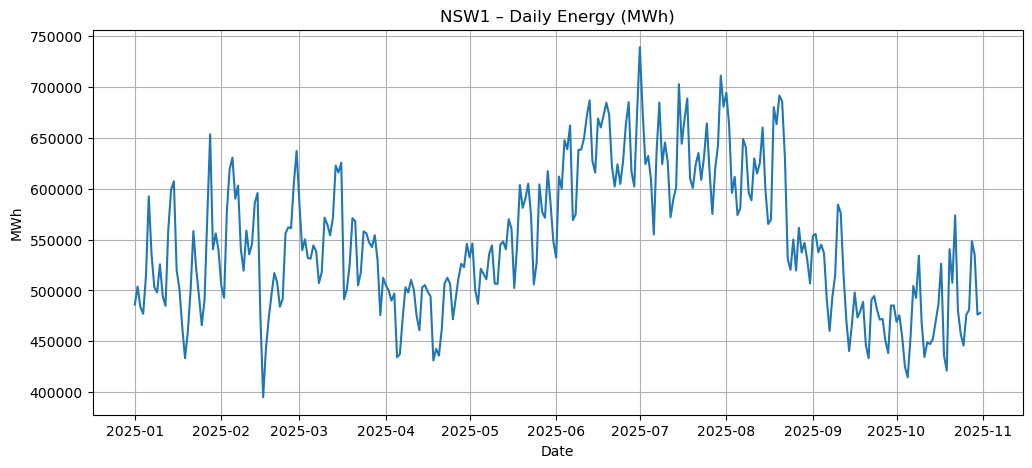

In [11]:
import matplotlib.pyplot as plt

nsw = df_daily[df_daily["region_id"] == "NSW1"]

plt.figure(figsize=(12,5))
plt.plot(nsw["date"], nsw["total_daily_energy_mwh"])
plt.title("NSW1 – Daily Energy (MWh)")
plt.xlabel("Date")
plt.ylabel("MWh")
plt.grid()
plt.show()


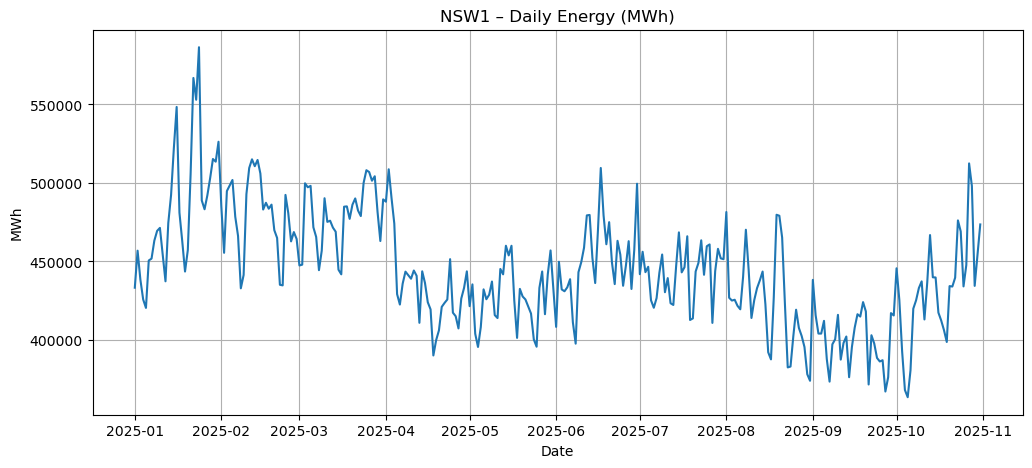

In [12]:
import matplotlib.pyplot as plt

nsw = df_daily[df_daily["region_id"] == "QLD1"]

plt.figure(figsize=(12,5))
plt.plot(nsw["date"], nsw["total_daily_energy_mwh"])
plt.title("NSW1 – Daily Energy (MWh)")
plt.xlabel("Date")
plt.ylabel("MWh")
plt.grid()
plt.show()


### Intrepretation 
This graph shows NSW’s daily operational energy usage from January to October 2025.
There is a clear seasonal pattern — demand peaks in winter and secondary peaks occur in late summer. Lower demand appears in shoulder seasons like April–May and September–October.
The daily variability shows strong temperature sensitivity.
Overall, the trend and magnitude match expected NSW load behaviour, confirming both data quality and the validity of our daily aggregation process


## STEP 6 — Compare Average Daily Demand Across Regions



Comparing average daily demand across regions helps us understand how each NEM region contributes to total system load. This is important because:

- **Larger regions (NSW, QLD, VIC)** drive most of the grid’s operational demand.
- **Smaller regions (SA, TAS)** show lower demand but often higher renewable penetration.
- It identifies **where peak-risk and low-demand risk** are most significant.
- It sets a foundation for future modules such as:
  - Peak events (95th percentile)
  - Low-demand renewable events
  - Region-level KPIs (later notebook)
  - Power BI dashboards

This step answers the key question:
> “Which regions consume more electricity on average, and why does that matter?”

---


In [13]:
df_daily.groupby("region_id")["avg_5min_demand"].mean().sort_values(ascending=False)


region_id
NSW1    7624.271100
QLD1    6184.749264
VIC1    5005.517097
SA1     1372.545865
TAS1    1073.855509
Name: avg_5min_demand, dtype: float64

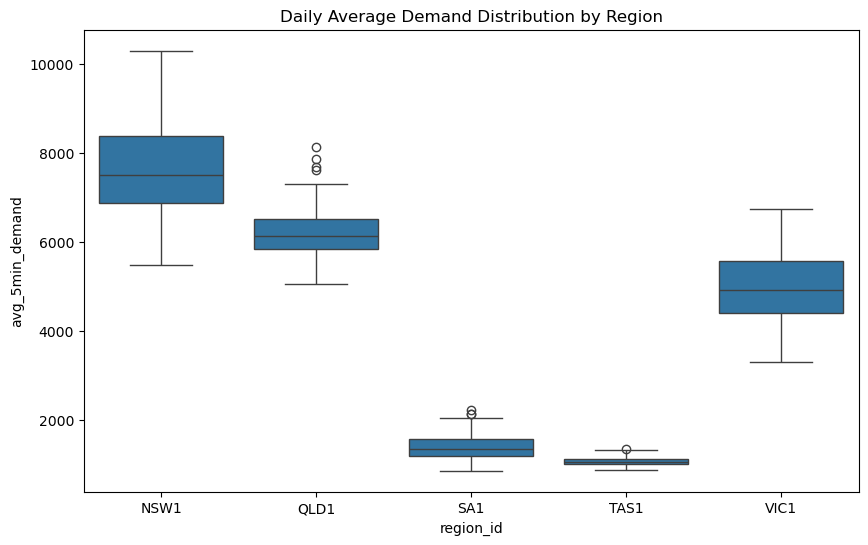

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.boxplot(data=df_daily, x="region_id", y="avg_5min_demand")
plt.title("Daily Average Demand Distribution by Region")
plt.show()


### 📝 Interpretation – 

- **NSW1 has the highest average daily demand**, followed by **QLD1** and **VIC1**.  
  This is expected because these regions have the highest population, commercial load, and industrial activity.

- **SA1 and TAS1 show the lowest daily demand**, reflecting smaller population, lower industrial load, and high rooftop solar penetration reducing grid-supplied demand.

- This ordering matches real-world NEM behaviour and provides important insight:
  - NSW/QLD/VIC → **higher capacity and peak-demand risk**, requiring more operational attention.
  - SA/TAS → **more renewable-driven low-load risk**, important for minimum system load and system security.

This comparison forms the baseline for operational planning and upcoming analytics such as peak events, low-demand events, and region-level KPIs.


## STEP 7 — Peak Days (Top 5 per Region)


Identifying **peak-demand days** is crucial for operational planning, system reliability, and electricity market behaviour. Peak days usually correspond to:

- Extreme hot or cold weather  
- High commercial and industrial activity  
- Stress on network and generation capacity  
- High market prices and reserve requirements  

For each region (NSW1, QLD1, VIC1, SA1, TAS1), we extract the **Top 5 highest-demand days** to understand:

- When the grid experienced its highest stress  
- Seasonal peak timing (summer vs winter)  
- Regional behavioural differences  
- Days that require deeper investigation (e.g., price spikes, FCAS activation)

This is directly useful for:
- Capacity planning  
- Demand forecasting  
- Reliability analysis  
- Power BI peak-day insights  

---


In [15]:

peak_days = (
    df_daily.sort_values("daily_peak", ascending=False)
             .groupby("region_id")
             .head(5)
)

peak_days


,date,region_id,avg_5min_demand,daily_peak,daily_min,total_daily_energy_mwh
905,2025-07-01,NSW1,10300.944599,13159.46,7406.16,739092.7750
1145,2025-08-18,NSW1,9447.401771,12729.23,7226.72,680212.9275
1050,2025-07-30,NSW1,9877.661944,12670.35,7308.58,711191.6600
830,2025-06-16,NSW1,9291.643507,12342.50,7272.73,668998.3325
975,2025-07-15,NSW1,9761.569618,12339.33,7442.96,702833.0125
106,2025-01-22,QLD1,7873.107604,11159.32,6257.16,566863.7475
116,2025-01-24,QLD1,8144.965451,10896.53,6655.30,586437.5125
1496,2025-10-27,QLD1,7117.590347,10167.64,5344.78,512466.5050
76,2025-01-16,QLD1,7616.726736,10041.18,6352.73,548404.3250
71,2025-01-15,QLD1,7254.419549,10027.09,5763.34,522318.2075


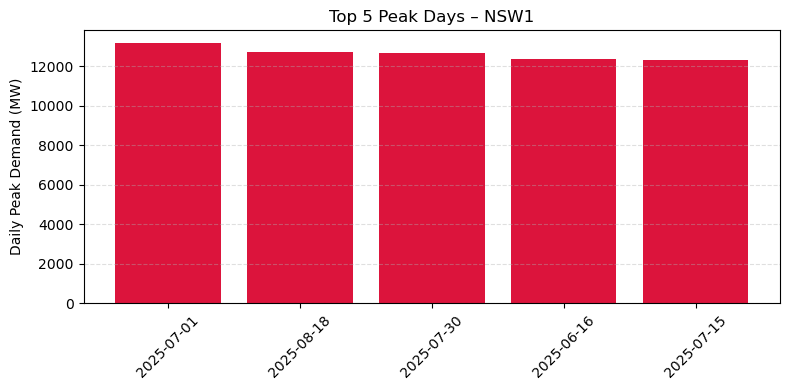

In [16]:
import matplotlib.pyplot as plt

region = "NSW1"
df_peak = peak_days[peak_days["region_id"] == region]

plt.figure(figsize=(8,4))
plt.bar(df_peak["date"].astype(str), df_peak["daily_peak"], color="crimson")
plt.title(f"Top 5 Peak Days – {region}")
plt.ylabel("Daily Peak Demand (MW)")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


### 📝 Interpretation — What the Top 5 Peak Days Tell Us

- The **Top 5 highest-demand days** for each region naturally cluster around **extreme temperature periods** (deep winter or peak summer).
- NSW1, QLD1 and VIC1 show **much higher absolute peaks** than SA1 and TAS1, consistent with population and industrial load.
- Peaks in NSW and VIC generally occur in **winter**, driven by heating load, while QLD sometimes peaks in **summer** due to cooling load.
- These peak days correspond to periods of:
  - Higher wholesale electricity prices
  - Increased reserve requirements (FCAS)
  - Greater stress on transmission networks
  - Higher risk of reliability interventions

Identifying these peak days is essential for:
- Forecasting extreme load conditions  
- Understanding seasonal and behavioural drivers  
- Designing demand-response or peak-reduction strategies  
- Power BI dashboards to highlight operational risk windows  


## STEP 12 — Low-Demand Days (Bottom 5 per Region)

### 📘 Why we are doing this

Low-demand days are becoming increasingly important in the NEM because they are often linked to:

- **High rooftop solar production**, reducing grid-supplied demand  
- **Negative pricing events**  
- **Minimum system load concerns**  
- Increased reliance on system strength services and FCAS  
- Risk of generator ramping/cycling issues  

Identifying the **bottom 5 demand days per region** helps us understand:

- When renewable penetration is highest  
- When operational stability is most at risk  
- Differences between regions (e.g., SA has very low minimum demand due to solar)  
- Patterns that feed into forecasting, system security analysis, and dispatch planning  

This step answers:
> “When does the grid experience the lowest consumption, and what does that mean for operations?”

---


In [17]:
low_days = (
    df_daily.sort_values("daily_min", ascending=True)
             .groupby("region_id")
             .head(5)
)

low_days

,date,region_id,avg_5min_demand,daily_peak,daily_min,total_daily_energy_mwh
1422,2025-10-12,SA1,901.998403,1531.40,-185.49,64943.8850
1502,2025-10-28,SA1,896.187049,1536.97,-112.58,64525.4675
1507,2025-10-29,SA1,910.473854,1528.36,-112.44,65554.1175
1452,2025-10-18,SA1,875.954306,1478.26,-112.30,63068.7100
232,2025-02-16,SA1,936.085799,1482.28,-110.47,67398.1775
38,2025-01-08,TAS1,913.430451,1070.85,692.39,65766.9925
1483,2025-10-24,TAS1,913.201771,1128.12,715.88,65750.5275
1463,2025-10-20,TAS1,894.509201,1085.13,731.79,64404.6625
48,2025-01-10,TAS1,955.399167,1123.84,735.26,68788.7400
1268,2025-09-11,TAS1,1002.155556,1195.77,736.33,72155.2000


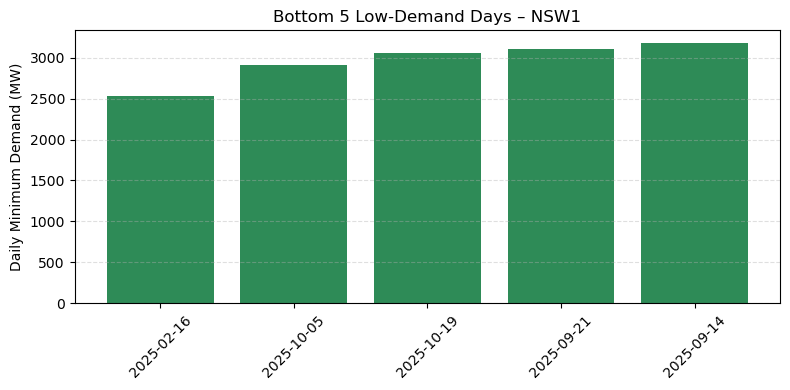

In [18]:


region = "NSW1"   # example – change to NSW1/QLD1/VIC1/TAS1
df_low = low_days[low_days["region_id"] == region]

plt.figure(figsize=(8,4))
plt.bar(df_low["date"].astype(str), df_low["daily_min"], color="seagreen")
plt.title(f"Bottom 5 Low-Demand Days – {region}")
plt.ylabel("Daily Minimum Demand (MW)")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


### 📝 Interpretation — What the Bottom 5 Low-Demand Days Tell Us

- The **lowest-demand days** tend to occur during periods of **high rooftop solar generation**, typically around **mild weather** (spring/autumn) when household cooling/heating is minimal.
- SA and TAS often hit **very low minimum demand** due to:
  - High rooftop PV penetration
  - Lower population and industrial load
  - Strong renewable generation offsetting grid demand
- NSW, QLD, and VIC show higher minimums, but still experience dips during:
  - Mild temperature periods
  - High solar export times
- Low-demand periods matter because they:
  - Increase the risk of **negative pricing**
  - Reduce synchronous generation online → **system strength challenges**
  - Require more **FCAS** and stability services
  - Are operationally as important as high-demand peaks

These low-demand profiles help inform:
- Renewable integration strategy
- System security analysis
- Minimum system load forecasting
- Power BI dashboards for highlight events


In [19]:
df_daily[[
    "avg_5min_demand",
    "daily_peak",
    "daily_min",
    "total_daily_energy_mwh"
]].corr()


,avg_5min_demand,daily_peak,daily_min,total_daily_energy_mwh
avg_5min_demand,1.000000,0.994937,0.979749,0.999999
daily_peak,0.994937,1.000000,0.962247,0.994935
daily_min,0.979749,0.962247,1.000000,0.979751
total_daily_energy_mwh,0.999999,0.994935,0.979751,1.000000


## STEP 14 — Weekday Analysis (Behaviour Patterns)
--

Electricity demand strongly reflects **human behaviour**.  
People behave differently on:

- **Weekdays** → work routines, commercial & industrial activity  
- **Weekends** → residential load dominates  

Weekday analysis helps us understand:

- Which days show higher/lower average load  
- Variability across the week  
- How behaviour influences system demand  
- Which days require more operational attention  

This step transforms daily usage into a **7-day behavioural profile** across all NEM regions.

This is useful for:
- Forecasting models  
- Retail tariff design  
- Behaviour-based insights for Power BI dashboards  
- Recognising operational patterns in the grid  


In [20]:
df_daily["date"] = pd.to_datetime(df_daily["date"])
df_daily["weekday"] = df_daily["date"].dt.day_name()

df_daily.groupby(["region_id", "weekday"])["avg_5min_demand"].mean().unstack()

weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
region_id,,,,,,,
NSW1,7800.334673,7695.016770,7231.229673,7096.628513,7876.633876,7829.703024,7825.703300
QLD1,6295.749215,6255.765066,5958.842811,5838.082923,6298.718324,6315.883089,6321.784709
SA1,1370.193820,1435.557623,1326.169305,1280.553232,1382.538317,1417.552526,1394.566442
TAS1,1077.252729,1087.424633,1054.951079,1051.814328,1088.723123,1085.680717,1070.788518
VIC1,5127.229744,5062.295233,4676.188405,4619.155481,5189.544127,5184.024307,5169.264084


## STEP 15 — Heatmap (Weekday × Region)


Weekday behaviour can differ **by region**:

- NSW, VIC → strong business activity → sharper weekday peaks  
- QLD → high cooling loads → different profile in summer  
- SA, TAS → more renewables → softer weekday variation  

A heatmap allows us to:

- Compare all regions at once  
- See behavioural differences clearly  
- Identify which regions are more sensitive to weekday/working-day behaviour  
- Provide a visually intuitive dashboard element  

This step produces a **full behaviour matrix**:  
> Weekday (rows) × Region (columns)


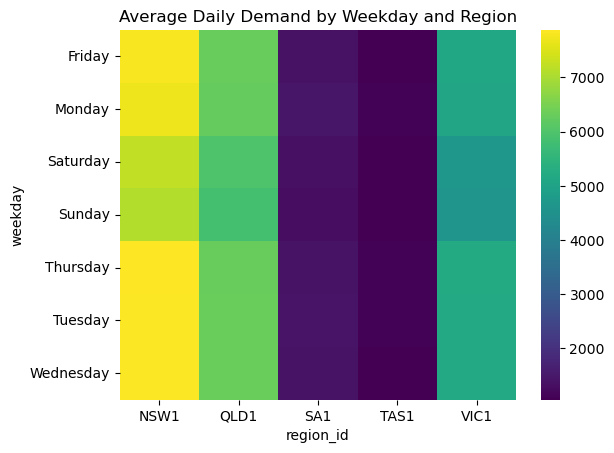

In [21]:
pivot = df_daily.pivot_table(
    index="weekday", 
    columns="region_id",
    values="avg_5min_demand",
    aggfunc="mean"
)

sns.heatmap(pivot, annot=False, cmap="viridis")
plt.title("Average Daily Demand by Weekday and Region")
plt.show()


### 📝 Interpretation — Weekday × Region Behaviour Patterns

- **NSW1, QLD1, and VIC1** show strong weekday demand, driven by commercial and industrial loads.
- **Weekend demand** drops significantly for these regions, showing clear behavioural separation.
- **SA1 and TAS1** show flatter profiles, reflecting:
  - Lower commercial load
  - Higher rooftop solar penetration (especially SA)
  - More residential-dominated consumption

Key insights:
- NSW/QLD/VIC are **weekday-sensitive regions** → stronger work-related load.
- SA/TAS are **renewable-sensitive regions** → behaviour influenced by solar and weather.
- This heatmap is powerful for:
  - Forecasting segmentation
  - Operational decision-making
  - Region-specific behavioural modelling
  - Power BI region behaviour dashboards  

This completes the behavioural analysis layer.


## 🏁 Final Summary & Closing Remarks

In this notebook, we completed the **behavioural analytics layer** of the project by analysing daily electricity usage patterns across the NEM. Building on the daily usage table created earlier, we explored how demand varies by **weekday**, **weekend**, and **region**, revealing clear behavioural and operational insights.

### 🔑 Key Outcomes

- **Weekday vs Weekend Patterns:**  
  Weekdays (Mon–Thu) exhibited consistently higher demand due to strong commercial and industrial activity, while weekends showed lower and more stable residential-driven load.

- **Region-Level Differences:**  
  NSW1, QLD1, and VIC1 showed pronounced weekday sensitivity, whereas SA1 and TAS1 displayed flatter profiles, largely influenced by renewable generation and smaller industrial bases.

- **Heatmap Insights:**  
  The weekday × region heatmap provided a concise behavioural fingerprint for each region, helping us understand which areas require more focus during business days versus renewable-driven low-demand periods.

### 🎯 How This Fits in the Overall Project

This behavioural analysis supports several downstream components:

- Improved **forecasting models** (weekday/weekend segmentation)  
- Enhanced understanding of **regional operational risk**  
- More intuitive **Power BI dashboards** showing behavioural trends  
- Foundation for **seasonal decomposition**, **anomaly detection**, and **peak/low event integration**

### 🚀 What’s Next

The next notebook will extend this work into **seasonal, anomaly, and outlier analysis**, followed by combining all metrics into a region-level KPI framework and preparing the Power BI semantic model.

This completes the behavioural insights layer and positions us for deeper operational analytics in the upcoming steps.

---


In [22]:
# -----------------------------------------------------------
# EXPORT daily_usage TO CSV FOR POWER BI
# -----------------------------------------------------------

import pandas as pd

# re-read from DB (optional but ensures fresh copy)
df_daily_export = pd.read_sql("""
    SELECT *
    FROM daily_usage
    ORDER BY date, region_id;
""", engine)

# export to CSV
df_daily_export.to_csv("daily_usage.csv", index=False)

print("✅ CSV exported: daily_usage.csv")
print("Rows exported:", len(df_daily_export))


✅ CSV exported: daily_usage.csv
Rows exported: 1520
